#  Dataset

## https://www.kaggle.com/datasets/teertha/ushealthinsurancedataset/data
This dataset contains 1338 rows of insured data, where the Insurance charges are given against the following attributes of the insured: Age, Sex, BMI, Number of Children, Smoker and Region. The data is used for EDA and Regression models for predicting Insurance Premium Charges.

# Libraries

In [67]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import RFE, SelectKBest, f_regression

# Models
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor, export_graphviz
from sklearn.ensemble import RandomForestRegressor


# Metric
from sklearn.metrics import mean_squared_error
import graphviz


# The Insurance Data

In [2]:
data=pd.read_csv('insurance.csv')

In [3]:
data.columns.to_list()

['age', 'sex', 'bmi', 'children', 'smoker', 'region', 'charges']

# EDA

In [4]:
data.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [5]:
data.tail()

,age,sex,bmi,children,smoker,region,charges
1333,50,male,30.97,3,no,northwest,10600.5483
1334,18,female,31.92,0,no,northeast,2205.9808
1335,18,female,36.85,0,no,southeast,1629.8335
1336,21,female,25.80,0,no,southwest,2007.9450
1337,61,female,29.07,0,yes,northwest,29141.3603


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [7]:
data.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


In [8]:
data.isna().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

# Extract the input features and the output variables

In [9]:
X=data.drop(['charges'],axis=1)
y=data['charges']
X.shape, y.shape

((1338, 6), (1338,))

# One-hot encoding

In [10]:
X_encoded=pd.get_dummies(X)
correlation_matrix=pd.concat([X_encoded,y], axis=1).corr()

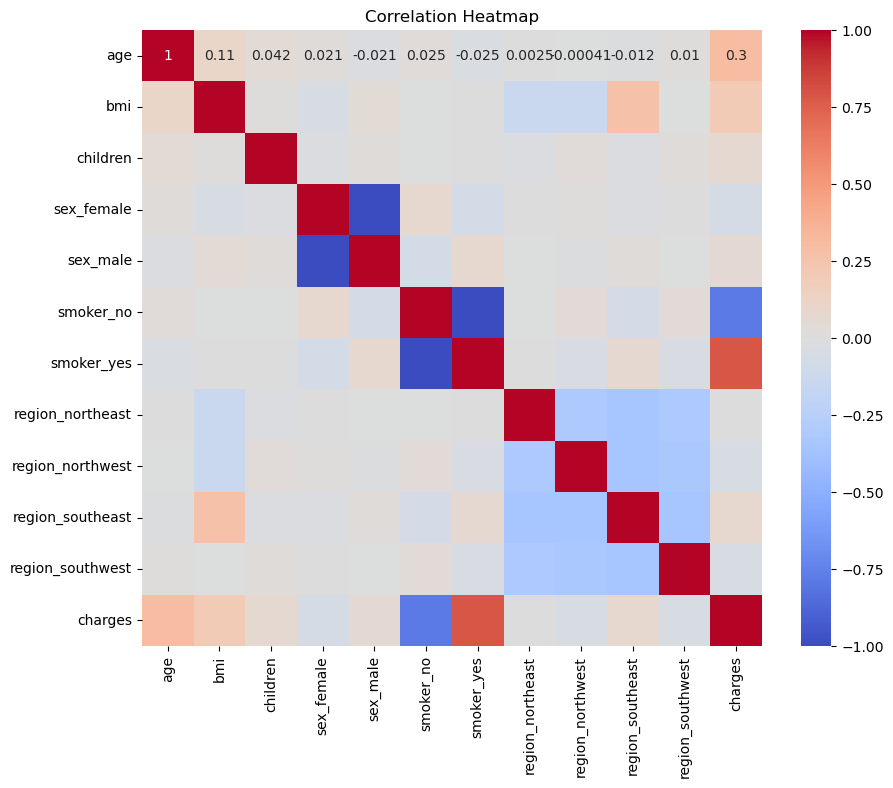

In [11]:
plt.figure(figsize=(10,8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()

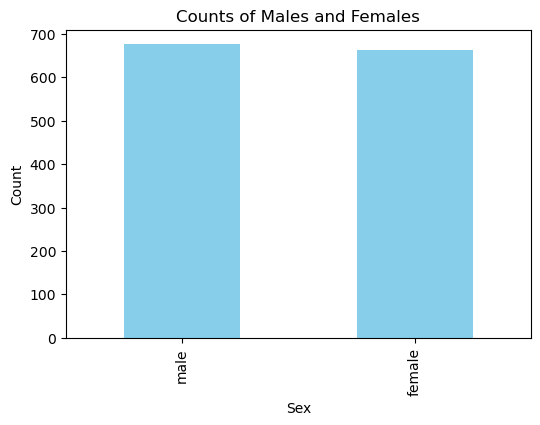

In [12]:
sex_counts=X['sex'].value_counts()
plt.figure(figsize=(6,4))
sex_counts.plot(kind='bar', color='skyblue')
plt.title('Counts of Males and Females')
plt.xlabel('Sex')
plt.ylabel('Count')
plt.show()

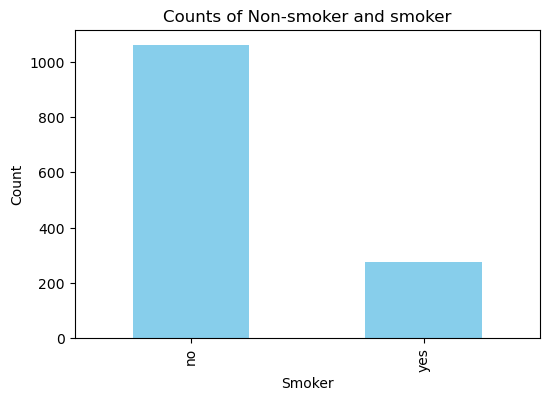

In [13]:
smokers_count=X['smoker'].value_counts()
plt.figure(figsize=(6,4))
smokers_count.plot(kind='bar', color='skyblue')
plt.title('Counts of Non-smoker and smoker')
plt.xlabel('Smoker')
plt.ylabel('Count')
plt.show()

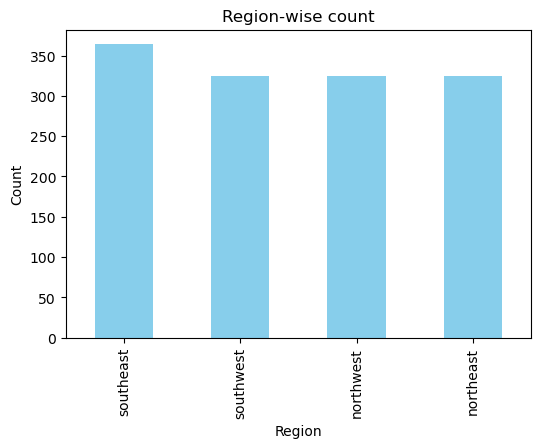

In [14]:
region_counts=X['region'].value_counts()
plt.figure(figsize=(6,4))
region_counts.plot(kind='bar', color='skyblue')
plt.title('Region-wise count')
plt.xlabel('Region')
plt.ylabel('Count')
plt.show()

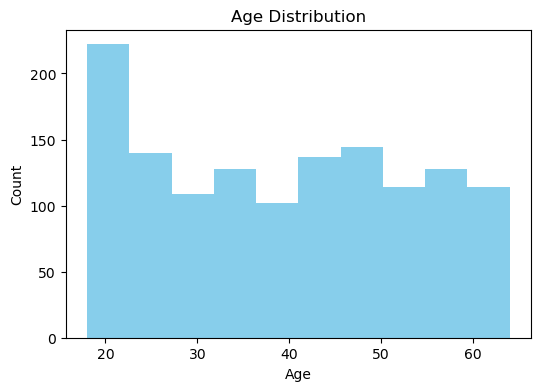

In [15]:
plt.figure(figsize=(6,4))
plt.hist(X['age'], bins=10, color='skyblue')      
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Count')
plt.show()

# Feature Selection

## Feature dropping

In [16]:
print('All input feature columns:', X.columns.to_list()) # all columns

All input feature columns: ['age', 'sex', 'bmi', 'children', 'smoker', 'region']


In [17]:
def featureSelection (X_all, y, featuresToDrop=None):
    if featuresToDrop is not None:
        X_selectedFeatures= X_all.drop(featuresToDrop,axis=1)
    else: 
        X_selectedFeatures= X_all
    X_encoded=pd.get_dummies(X_selectedFeatures)
    X_train, X_test, y_train, y_test = train_test_split(X_encoded,y,test_size=0.2, random_state=42)
    print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
    print("Selected Features:", X_selectedFeatures.columns.to_list())
    return X_train, X_test, y_train, y_test

In [18]:
X_train, X_test, y_train, y_test=featureSelection(X,y) # list columns to drop here

(1070, 11) (268, 11) (1070,) (268,)
Selected Features: ['age', 'sex', 'bmi', 'children', 'smoker', 'region']


## Recursive Feature Elimation (RFE)

In [19]:
num_features=3
classifier=LogisticRegression()

In [20]:
feature_names= X_train.columns.to_list()
# Perform feature selection using SelectKBest
selector = SelectKBest(score_func=f_regression, k=num_features)
X_selected = selector.fit_transform(X_train, y_train)

# Get the selected feature indices
selected_indices = selector.get_support(indices=True)

# Get the selected feature names
selected_features = [feature_names[i] for i in selected_indices]

# Print the selected feature names
print("Selected features:", selected_features)

Selected features: ['age', 'smoker_no', 'smoker_yes']


# Model: Linear Regression

In [21]:
pipeline= Pipeline(
    [
        ('scaler', StandardScaler()),
        ('regressor',LinearRegression())
     ]
)

In [22]:
param_grid= {
    'regressor__fit_intercept':[True, False]
}

In [23]:
grid_search=GridSearchCV(pipeline, param_grid, cv=5)
grid_search.fit(X_train,y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('regressor', LinearRegression())]),
             param_grid={'regressor__fit_intercept': [True, False]})

In [24]:
print("Best Hyperparameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

Best Hyperparameters: {'regressor__fit_intercept': True}
Best Score: 0.7331213671246919


In [25]:
test_score=grid_search.score(X_test,y_test)
print("Test Score:",test_score)

Test Score: 0.7835929767120722


# Model: SVM

In [26]:
pipeline=Pipeline(
    [
        ('scaler', StandardScaler()),
        ('regressor', SVR())
    ]
)

In [27]:
param_grid={
    'regressor__C': [0.001, 0.1, 1, 10, 100],
    'regressor__kernel': ['linear', 'rbf', 'poly'],    
    'regressor__gamma': ['scale', 'auto']

}

In [28]:
grid_search=GridSearchCV(pipeline,param_grid,cv=5)
grid_search.fit(X_train,y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('regressor', SVR())]),
             param_grid={'regressor__C': [0.001, 0.1, 1, 10, 100],
                         'regressor__gamma': ['scale', 'auto'],
                         'regressor__kernel': ['linear', 'rbf', 'poly']})

In [29]:
print("Best parameters:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)

Best parameters: {'regressor__C': 100, 'regressor__gamma': 'scale', 'regressor__kernel': 'linear'}
Best score: 0.6471572736430752


# Model: Decision tree

In [31]:
pipeline=Pipeline(
    [
        ('regressor', DecisionTreeRegressor())

    ]

)

In [61]:
param_grid= {
    'regressor__max_depth': [None, 2, 5, 10],
    'regressor__min_samples_split': [2, 5, 10]

}

In [62]:
grid_search=GridSearchCV(pipeline, param_grid, cv=5)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('regressor', DecisionTreeRegressor())]),
             param_grid={'regressor__max_depth': [None, 2, 5, 10],
                         'regressor__min_samples_split': [2, 5, 10]})

In [63]:
print("Best parameters:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)

Best parameters: {'regressor__max_depth': 5, 'regressor__min_samples_split': 2}
Best score: 0.8209113128007438


In [64]:
# test data performance
best_model= grid_search.best_estimator_
y_pred=best_model.predict(X_test)
mse=mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

Mean Squared Error: 25857792.05855163


In [65]:
regressor=DecisionTreeRegressor(max_depth=5,min_samples_split=2)
regressor.fit(X_train, y_train)


DecisionTreeRegressor(max_depth=5)

In [66]:
# Viewing deicsion tree
'''
dot_data=export_graphviz( regressor, out_file=None, feature_names=X_train.columns.to_list())
graph=graphviz.Source(dot_data)
graph.render("decision_tree")
graph.view()
'''

'\ndot_data=export_graphviz( regressor, out_file=None, feature_names=X_train.columns.to_list())\ngraph=graphviz.Source(dot_data)\ngraph.render("decision_tree")\ngraph.view()\n'

# Model: RandomForest

In [69]:
pipeline= Pipeline(
    [
        ('scaler', StandardScaler()),
        ('regressor', RandomForestRegressor())

    ]
)

In [74]:
param_grid={
    'regressor__n_estimators':[100, 200, 300],
    'regressor__max_depth': [None, 5, 10]

}

In [75]:
grid_search=GridSearchCV(pipeline, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('regressor', RandomForestRegressor())]),
             param_grid={'regressor__max_depth': [None, 5, 10],
                         'regressor__n_estimators': [100, 200, 300]},
             scoring='neg_mean_squared_error')

In [81]:
best_model= grid_search.best_estimator_
best_params=grid_search.best_params_
print("best model:", best_model)
print("best parameters:", best_params)
print("best score:", grid_search.best_score_)

best model: Pipeline(steps=[('scaler', StandardScaler()),
                ('regressor',
                 RandomForestRegressor(max_depth=5, n_estimators=300))])
best parameters: {'regressor__max_depth': 5, 'regressor__n_estimators': 300}
best score: -21873825.761327706


In [80]:
y_pred= best_model.predict(X_test)
mse=mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

Mean Squared Error: 19802951.733241137
